**Created By :** *Aakash Khandelwal*  
*8th May 2019*  

## **Work In Progress**



### Key Data Observations
* Total no. of **observations **is **27820** and** 12 columns** namely -
    * country
    * year 
    * sex 
    * age 
    * suicides_no 
    * population 
    * suicides/100k pop 
    * country-year 
    * HDI for year
    * gdp_for_year 
    * gdp_per_capita 
    * generation
* **HDI for year** has missing values for more than 19K records which makes of around 70% of total no. of observations.
* Data is **missing for various countries for various years but in 2016, no suicides data is available for 85 countries**.
* Countries were cluubed in various **continents** using geonamescache packages.
* Multiple analysis can be done based on **groupping data** by :
    * age
    * sex
    * country
    * gdp_per_capita
    * year
* Suicide Rate is calculated as (total no. of suicides / total population)* 100000.




In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
!pip install geonamescache
import geonamescache


# read data
suicides_data = pd.read_csv('../input/master.csv')

    100% |████████████████████████████████| 788kB 12.7MB/s 
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Data Cleaning
* HDI for year is dropped, a spearated dataset is created where analysis is done based on HDI
* Countries for which suicide data is available for less than 10 years have been dropped
* Continents were mapped to countries
* Data for year 2016 is dropped due to very few observations

In [2]:
# Dropping HDI for year column due to 70% of missing observations
#pd.DataFrame(zip(suicides_data.columns,suicides_data.notnull().sum(),suicides_data.isnull().sum()),columns = ['ColumnName', 'Non-Missing Values','Missing Values'])
data = suicides_data.drop(['HDI for year'], axis = 1)

# Countries removed where data is avalable for less than 10 years only
by_countryYear = data.groupby('country')['year'].nunique().reset_index()
countries = list(by_countryYear[by_countryYear['year']>=10]['country'])
data = data[data['country'].isin(countries)]

# Mapped Continent to countries
gc = geonamescache.GeonamesCache()
countries = gc.get_countries()
mapping = pd.DataFrame(countries).T.reset_index()[['name','continentcode']]
mapping.rename(columns = {'name':'country'}, inplace=True)
mapping['country'] = mapping['country'].replace({'Macao':'Macau',
                                   'Czechia':'Czech Republic',
                                   'South Korea':'Republic of Korea',
                                   'Russia':'Russian Federation',
                                   'Saint Vincent and the Grenadines':'Saint Vincent and Grenadines'})

data = pd.merge(data,mapping,on='country', how = 'left')
data['continentcode'] = data['continentcode'].replace({'EU':'Europe',
                                   'AS':'Asia',
                                   'NA':'North America',
                                   'SA':'South America',
                                   'AF':'Africa',
                                   'OC':'Oceania'})

# converting columns to catgegory data type
data['continentcode'] = pd.Categorical(data['continentcode'])
data['age'] = pd.Categorical(data['age'])
data['age'].cat.reorder_categories(['5-14 years','15-24 years','25-34 years',
                                    '35-54 years','55-74 years','75+ years'], inplace = True)
data['generation'] = pd.Categorical(data['generation'])
data['generation'].cat.reorder_categories(['G.I. Generation','Silent','Boomers','Generation X','Millenials','Generation Z'],
                                          inplace = True)
data['country'] = pd.Categorical(data['country'])
data['sex'] = pd.Categorical(data['sex'])
data.rename(columns = {'continentcode':'continent'},inplace = True)

# data for year 2016 is removed due to very less observations 
#data.pivot_table(values = 'suicides_no',index = 'country',columns = 'year',aggfunc='sum').isnull().sum()
data = data[data['year'] != 2016]

## Suicide Rate trend across year by continent, age group, gender and generations

#### Suicides Rate Across Globe - 
Suicides rates were increasing in the starting years, reached a maximum in 1995 and since then is decreasing across the globe.

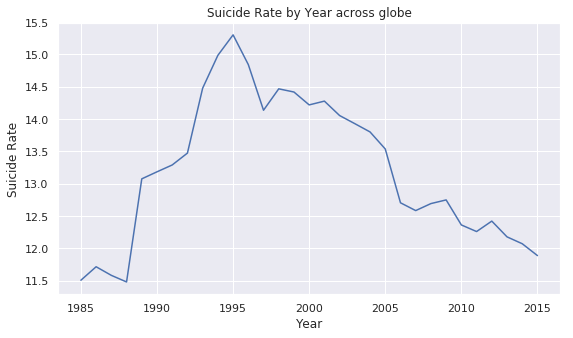

In [3]:
plt.figure(figsize=(9,5))
by_year = data.groupby(['year'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",data=by_year)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Year across globe')
plt.show()

#### Suicide Rates By Continent
* Remains constant in South America and North America, with ups and downs in Asia and Oceania continents.
* Highest rates have been observed in Europe where as lowest was seen in South America.
* There is sharpe descrease in suicde rates in Africa, after year 1995, indicating less data or issues in collecting data for countries in Africa.
* A decreasing trend is observed in Europe, still being the highes among all continents.

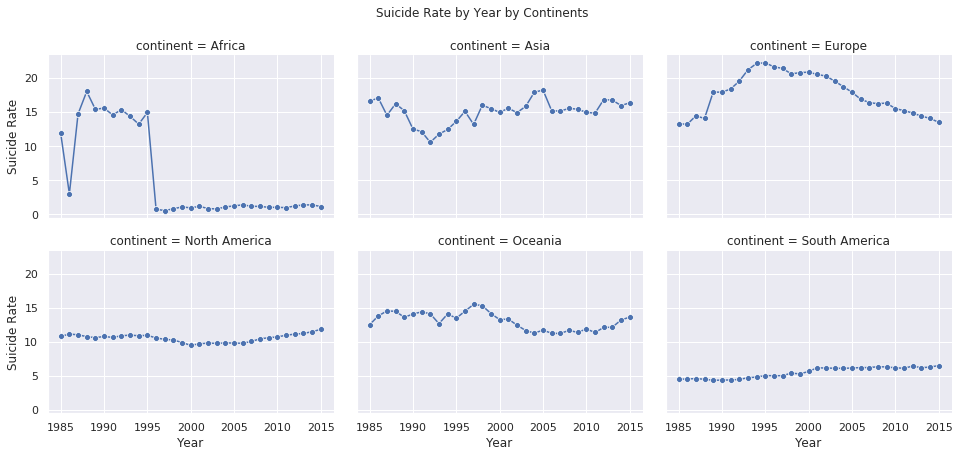

In [4]:
by_continent = data.groupby(['continent','year'])[['population','suicides_no']].sum().reset_index()
by_continent['suicide_rate'] = by_continent['suicides_no']*100000/by_continent['population']
sns.set_style("darkgrid")
ax = sns.relplot(x="year", y="suicide_rate", col="continent",col_wrap=3,
                 data=by_continent , kind="line", legend="full", marker='o',
                height=3, aspect=1.5)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by Year by Continents', x=0.5, y=1.05)
plt.show()

#### Suicide Rates by Gender
Males have very high suicide rate as compared to females.

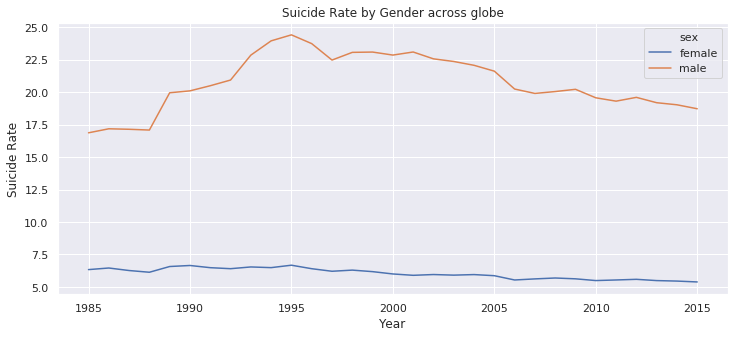

In [5]:
plt.figure(figsize=(12,5))
by_year = data.groupby(['year','sex'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'sex',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Gender across globe')
plt.show()

#### Suicide Rate by Age Group and Generation

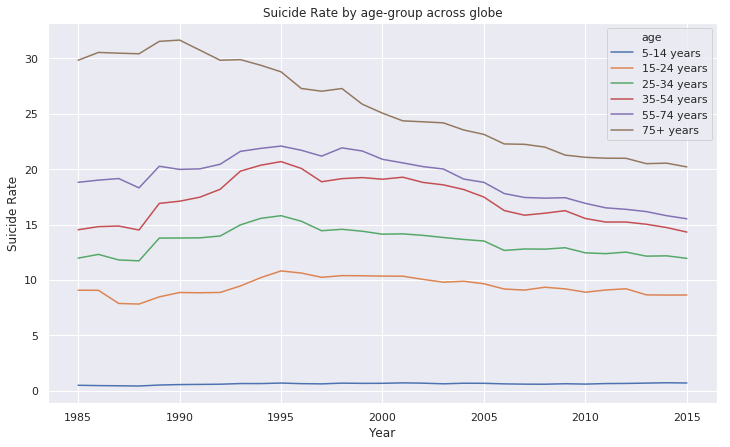

In [6]:
plt.figure(figsize=(12,7))
by_year = data.groupby(['year','age'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'age',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by age-group across globe')
plt.show()

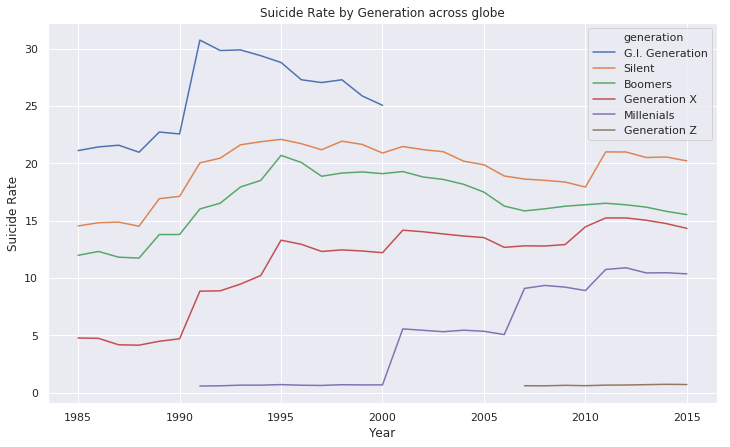

In [7]:
plt.figure(figsize=(12,7))
by_year = data.groupby(['year','generation'])[['population','suicides_no']].sum().reset_index()
by_year['suicide_rate'] = by_year['suicides_no']*100000/by_year['population']
ax = sns.lineplot(x="year", y="suicide_rate",hue = 'generation',data=by_year,  legend="full")
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Suicide Rate by Generation across globe')
plt.show()

## By gender, age and generation

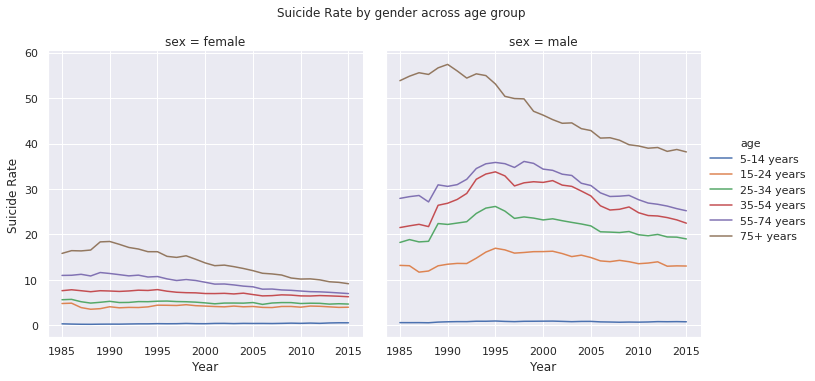

In [8]:
by_sex = data.groupby(['year','sex','age'])[['population','suicides_no']].sum().reset_index()
by_sex['suicide_rate'] = by_sex['suicides_no']*100000/by_sex['population']
ax = sns.relplot(x="year", y="suicide_rate", hue="age",  col="sex",data=by_sex,  kind="line", legend="full",
                height=5, aspect=1)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by gender across age group', x=0.5, y=1.05)
plt.show()
plt.show()

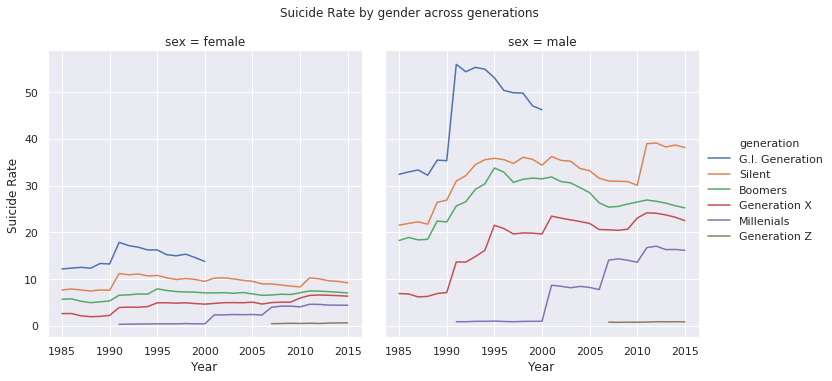

In [9]:
by_gen_year = data.groupby(['year','sex','generation'])[['population','suicides_no']].sum().reset_index()
by_gen_year['suicide_rate'] = by_gen_year['suicides_no']*100000/by_gen_year['population']
ax = sns.relplot(x="year", y="suicide_rate", hue="generation",  col="sex",data=by_gen_year,  kind="line", legend="full",
                height=5, aspect=1)
ax.set(ylabel='Suicide Rate', xlabel='Year')
ax.fig.suptitle('Suicide Rate by gender across generations', x=0.5, y=1.05)
plt.show()

## By generation and age group

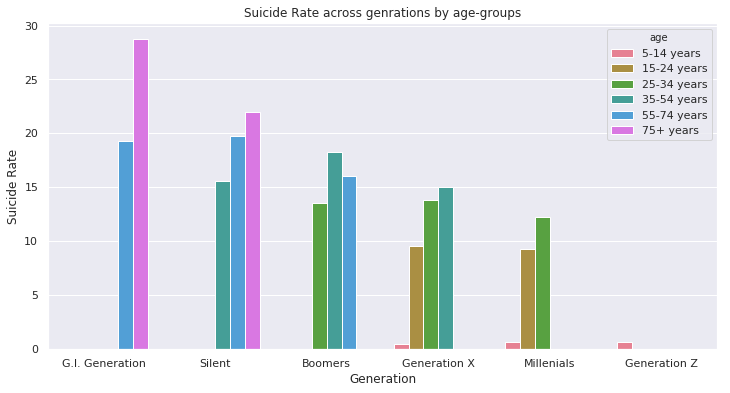

In [10]:
age_gen_suicideno = data.pivot_table(values = 'suicides_no',index = 'generation',columns = 'age',aggfunc='sum')
age_gen_population = data.pivot_table(values = 'population',index = 'generation',columns = 'age',aggfunc='sum')
by_age_gen = age_gen_suicideno*100000/age_gen_population
by_age_gen = by_age_gen.stack().reset_index(name='suicide_rate')
plt.figure(figsize=(12,6))
sns.set_palette("husl", 6)
ax = sns.barplot(x = 'generation',y = 'suicide_rate', hue='age',data=by_age_gen)
ax.legend(loc =1, title = 'age')
ax.set(ylabel='Suicide Rate', xlabel='Generation', title = 'Suicide Rate across genrations by age-groups')
plt.show()

## By GDP

In [11]:
#by_gdpcapita = data.groupby(['gdp_per_capita ($)'])[['population','suicides_no']].sum().reset_index()
#by_gdpcapita['suicide_rate'] = by_gdpcapita['suicides_no']*100000/by_gdpcapita['population']
#plt.figure(figsize=(12,7))
#sns.scatterplot(x="gdp_per_capita ($)", y="suicide_rate", data=by_gdpcapita)
#by_gdpcapita[['gdp_per_capita ($)','suicide_rate']].corr()

A very weak positive correlation is observed between suicide rate and country's GDP per capita, where it is also found that countries with high GDP have sucide rate more than 10.

,gdp_per_capita ($),suicide_rate
gdp_per_capita ($),1.000000,0.088597
suicide_rate,0.088597,1.000000


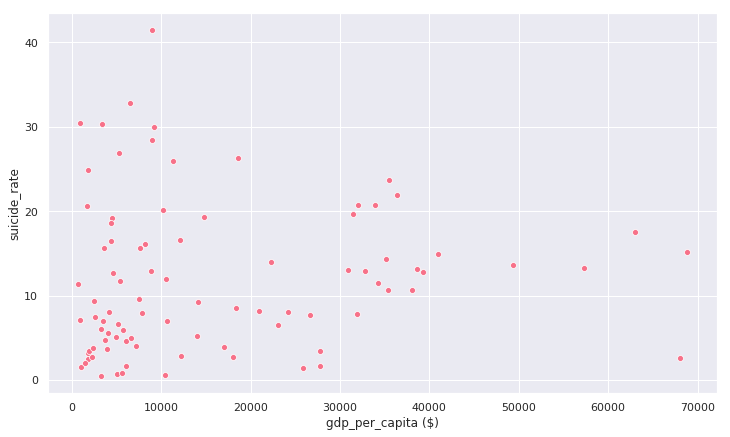

In [12]:
by_gdp_country = data.groupby(['country']).agg({'population':'sum', 
                         'suicides_no':'sum', 
                         'gdp_per_capita ($)':'mean'}).reset_index()
by_gdp_country['suicide_rate'] = by_gdp_country['suicides_no']*100000/by_gdp_country['population']
plt.figure(figsize=(12,7))
sns.scatterplot(x="gdp_per_capita ($)", y="suicide_rate", data=by_gdp_country)
by_gdp_country[['gdp_per_capita ($)','suicide_rate']].corr()

## Countries with increasing/decreasing trend in suicide rate throughout the time period

In [13]:
dm = data.groupby(['country','year'])['suicides_no','population'].sum().reset_index()
dm['suicide_rate'] = dm['suicides_no']*100000/dm['population']
dm = dm[dm['suicides_no'].notnull()]
from sklearn.linear_model import LinearRegression
b = []
for country in dm.country.unique():
    tempdf = dm[dm['country'] == country]
    X = np.asarray(tempdf['year']).reshape([-1,1])
    y = np.asarray(tempdf['suicide_rate']).reshape([-1,1])
    model = LinearRegression()
    results = model.fit(X,y).coef_[0][0]
    b.append([country,results])

df = pd.DataFrame(b,columns=['country','factor']).sort_values(by='factor')
decrease = list(df['country'].head(10))
increase = list(df['country'].tail(10))

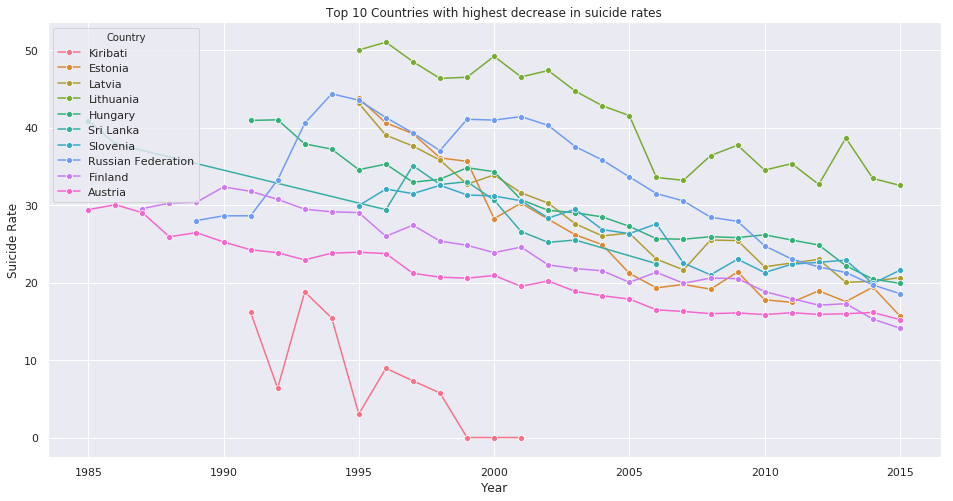

In [14]:
plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 10)
for country in decrease:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='upper left', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 10 Countries with highest decrease in suicide rates')
plt.show()

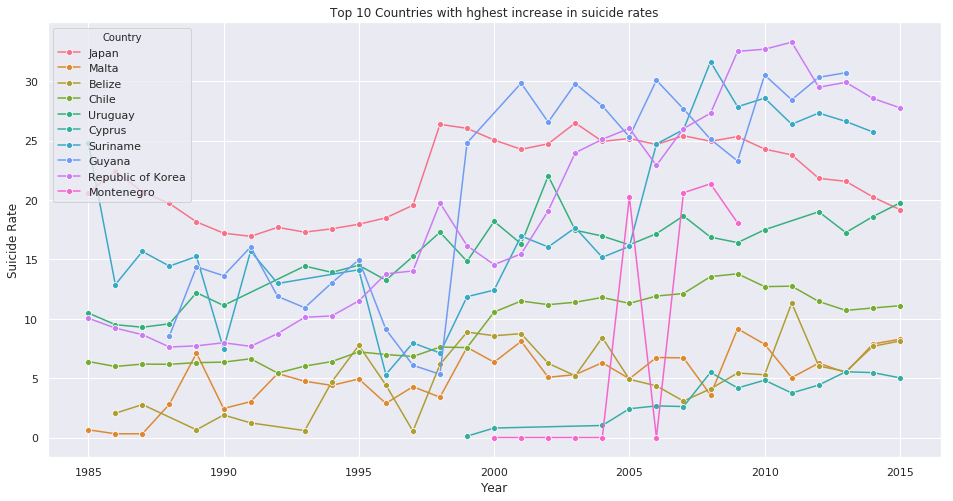

In [15]:
plt.figure(figsize=(16,8))
leg = []
sns.set_palette("husl", 10)
for country in increase:
    dm_country = dm[dm['country'] == country]
    ax = sns.lineplot(x="year", y="suicide_rate",data=dm_country, marker='o')
    leg.append(country)

plt.legend(title='Country', loc='best', labels=leg)
ax.set(ylabel='Suicide Rate', xlabel='Year', title = 'Top 10 Countries with hghest increase in suicide rates')
plt.show()

## By human development index 
As HDI for year column contains missing values to around 70%, the data si filtered for recent years i.e., 2012,2011,2012,2013 and 2014 and those countries were removed where data is missing for these years.

Coutries were divided based on the HDI categories -** Very High, High, Medium and Low**
**World map representing Human Development Index categories **
![World map representing Human Development Index categories ](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/2018_UN_Human_Development_Report.svg/1920px-2018_UN_Human_Development_Report.svg.png)
Source : [Wikipedia](https://en.wikipedia.org/wiki/Human_Development_Index)

This was found the, there exist a correlation of 0.43 (weak positive correlation) between suicide rates and HDI, indicating that suicide rates is high among countries with high human development index. 

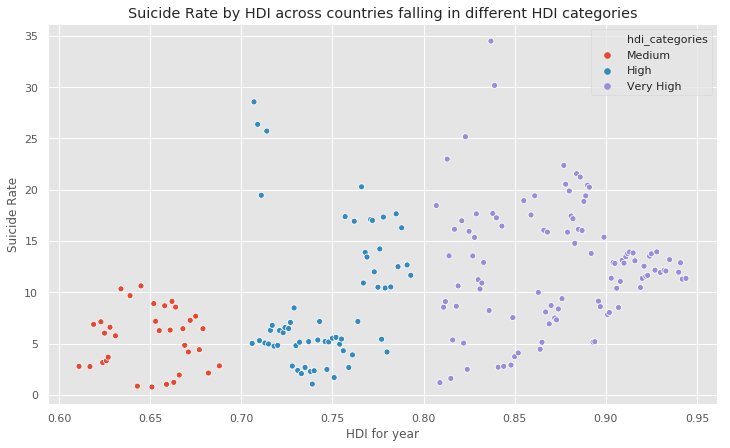

,HDI for year,suicide_rate
HDI for year,1.000000,0.426826
suicide_rate,0.426826,1.000000


In [16]:
# Basic Cleaning
data_withHDI = suicides_data.copy()
data_withHDI = data_withHDI[data_withHDI['HDI for year'].notnull()]
#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
# Filetred Years
data_withHDI = data_withHDI[data_withHDI['year'].isin([2010,2011,2012,2013,2014])]
# Filtered Countries
#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
countries = list(data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year') \
                 .dropna().reset_index()['country'])
data_withHDI = data_withHDI[data_withHDI['country'].isin(countries)]
#data_withHDI.pivot_table(values = 'HDI for year',index = 'country',columns = 'year').isnull().sum()
by_hdi = data_withHDI.groupby(['HDI for year'])[['population','suicides_no']].sum().reset_index()
by_hdi['suicide_rate'] = by_hdi['suicides_no']*100000/by_hdi['population']
# HDI Categories
by_hdi['hdi_categories'] = np.where(by_hdi['HDI for year'] >=0.8, "Very High",
                             np.where(by_hdi['HDI for year'].between(0.7,0.799), "High",
                             np.where(by_hdi['HDI for year'].between(0.555,0.699),"Medium","Low")))

# Plot and Correlation
plt.figure(figsize=(12,7))
plt.style.use('ggplot')
ax = sns.scatterplot(x="HDI for year", y="suicide_rate", hue= 'hdi_categories', data=by_hdi)
ax.set(ylabel='Suicide Rate', xlabel='HDI for year', title = 'Suicide Rate by HDI across countries falling in different HDI categories')
plt.show()
by_hdi[['HDI for year','suicide_rate']].corr()